In [ ]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning==2.0.0
!pip install --upgrade numpy

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/DRseg')
from pprint import pprint
from torch.utils.data import DataLoader
BATCH_SIZE=1
THRESHOLD=0.2

In [ ]:
# New dataloader
import torchvision
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image
from torch.utils.data import Dataset
DATASET_PATH='/content/drive/MyDrive/dataset/DDR-dataset/lesion_segmentation'
CKPT_PATH="/content/drive/MyDrive/DRseg/SAVE/"
INPUT_SIZE=512
# this is running on server
class SEGData(Dataset):  # 继承Dataset这个类
    def __init__(self,mode,lesionCategory):
        self.img_path = DATASET_PATH+'/'+mode+'/image'
        self.label_path = DATASET_PATH+'/'+mode+'/label/'+lesionCategory
        self.label_data = os.listdir(self.label_path)
        self.totensor=torchvision.transforms.ToTensor()
        self.resizer=torchvision.transforms.Resize((INPUT_SIZE,INPUT_SIZE))
        self.resizer1 = torchvision.transforms.Resize((1536, 1536))
        self.tenCropper = torchvision.transforms.TenCrop(1024, vertical_flip=True)
    def __len__(self):
        return len(self.label_data)
    def __getitem__(self, item):
        img_name = os.path.join(self.img_path, self.label_data[item])
        img_name = os.path.split(img_name) # 以 "PATH" 中最后一个 '/' 作为分隔符，分隔后，将索引为0的视为目录（路径），将索引为1的视为文件名
        img_name = img_name[-1]
        img_name = img_name.split('.')
        img_name = img_name[0] + '.jpg' # label is .tif format,while image is .jpg
        img_data = os.path.join(self.img_path, img_name)
        label_data = os.path.join(self.label_path, self.label_data[item])
        # 将图片和标签都转为正方形
        img = Image.open(img_data) # fp -文件名 (字符串)，pathlib.Path对象或文件对象
        label = Image.open(label_data)
        w, h = img.size

        slide=min(h,w)
        center_cropper=torchvision.transforms.CenterCrop(slide)
        cropped_img = center_cropper(img)
        cropped_label = center_cropper(label)
        res_img=self.resizer1(cropped_img)
        res_label=self.resizer1(cropped_label)
        ten_cropped_imgs = list(self.tenCropper(res_img))
        ten_cropped_labels = list(self.tenCropper(res_label))
        for i in range(10):
            ten_cropped_imgs[i]=self.totensor(self.resizer(  ten_cropped_imgs[i]))
        for i in range(10):
            ten_cropped_labels[i] =self.totensor( self.resizer(ten_cropped_labels[i]))
        flipped_img =self.totensor( self.resizer(cropped_img.transpose(Image.FLIP_LEFT_RIGHT) )) # 水平翻转
        flipped_label =self.totensor(self.resizer( cropped_label.transpose(Image.FLIP_LEFT_RIGHT)) ) # 水平翻转
        imgs=[self.totensor(self.resizer(cropped_img))]+ten_cropped_imgs+[flipped_img]
        labels=[self.totensor(self.resizer(cropped_label))]+ten_cropped_labels +[flipped_label]
        img_tensor=torch.stack(tuple(imgs))
        label_tensor = torch.stack(tuple(labels))
        return{ "image":img_tensor,"mask":label_tensor}

In [ ]:
# Train dataloader
import torchvision
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image
from torch.utils.data import Dataset
DATASET_PATH='/content/drive/MyDrive/AugmentedData'
CKPT_PATH="/content/drive/MyDrive/DRseg/SAVE/"
INPUT_SIZE=512
# this is running on server
class SEGData(Dataset):  # 继承Dataset这个类
    def __init__(self,mode,lesionCategory):
        self.img_path = DATASET_PATH+'/image/'
        self.label_path = DATASET_PATH+'/label/'+lesionCategory+'/'
        self.img_data = os.listdir(self.img_path)
        self.totensor=torchvision.transforms.ToTensor()
    def __len__(self):
        return len(self.label_data)
    def __getitem__(self, item):
        img_name = self.img_data[item]


        this_img_path = os.path.join(self.img_path, img_name)
        this_label_path = os.path.join(self.label_path, img_name)
        img = Image.open(this_img_path) # fp -文件名 (字符串)，pathlib.Path对象或文件对象
        label = Image.open(this_label_path)

        img_tensor=self.totensor(img)
        label_tensor = self.totensor(label)
        return{ "image":img_tensor,"mask":label_tensor}

In [ ]:
# test and valid dataloader
import torchvision
from PIL import Image
from torch.utils.data import Dataset
DATASET_PATH='/content/drive/MyDrive/dataset/DDR-dataset/lesion_segmentation'
INPUT_SIZE=512
# this is running on server
class TestData(Dataset):  # 继承Dataset这个类
    def __init__(self,mode,lesionCategory):
        self.img_path = DATASET_PATH+'/'+mode+'/image'
        self.label_path = DATASET_PATH+'/'+mode+'/label/'+lesionCategory
        self.label_data = os.listdir(self.label_path)
        self.totensor=torchvision.transforms.ToTensor()
        self.resizer=torchvision.transforms.Resize((INPUT_SIZE,INPUT_SIZE))
    def __len__(self):
        return len(self.label_data)
    def __getitem__(self, item):
        img_name = os.path.join(self.img_path, self.label_data[item])
        img_name = os.path.split(img_name) # 以 "PATH" 中最后一个 '/' 作为分隔符，分隔后，将索引为0的视为目录（路径），将索引为1的视为文件名
        img_name = img_name[-1]
        img_name = img_name.split('.')
        img_name = img_name[0] + '.jpg' # label is .tif format,while image is .jpg
        img_data = os.path.join(self.img_path, img_name)
        label_data = os.path.join(self.label_path, self.label_data[item])
        # 将图片和标签都转为正方形
        img = Image.open(img_data) # fp -文件名 (字符串)，pathlib.Path对象或文件对象
        label = Image.open(label_data)
        w, h = img.size
        slide=min(h,w)
        center_cropper=torchvision.transforms.CenterCrop(slide)
        cropped_img=self.resizer(center_cropper(img))
        cropped_label=self.resizer(center_cropper(label))
        cropped_img=self.totensor(cropped_img)
        cropped_label=self.totensor(cropped_label)

        return{ "image":cropped_img,"mask":cropped_label}

In [ ]:
# packages for image augmentation
!pip install imgaug
!pip install imagecorruptions

In [ ]:
# augment image
import imageio
import numpy as np
import os
import random
import imgaug.augmenters as iaa
from matplotlib import pyplot as plt

DATASET_PATH = '/content/drive/MyDrive/dataset/DDR-dataset/lesion_segmentation/train'
SAVE_PATH = "/content/drive/MyDrive/AugmentedData"
lesionCategory = "HE"

img_dir = DATASET_PATH + '/image'
label_dir = DATASET_PATH + '/label/' + lesionCategory
label_names = os.listdir(label_dir)
SIZE1,SIZE2,SIZE3,SIZE4=1536,1024,768,512
for item in range(len(label_names)):
    label_name=label_names[item]
    img_name = label_name.split('.')
    img_name = img_name[0] + '.jpg'  # label is .tif format,while image is .jpg
    img_path = os.path.join(img_dir, img_name)
    label_path = os.path.join(label_dir, label_names[item])
    image = imageio.v3.imread(img_path)
    label= imageio.v3.imread(label_path)
    h,w=image.shape[0],image.shape[1]
    slide=min(h,w)
    if h>=w:
        area=(-int(h/2-slide/2),-0,-int(h/2-slide/2),0)
        centerCropper = iaa.CropAndPad(area,keep_size=False) # top right bottom left means remove how much
    else:
        area=(0, -int(w / 2 - slide / 2), -0, -int(w / 2 - slide / 2))
        centerCropper = iaa.CropAndPad( area ,keep_size=False) # top right bottom left
    segmentation_maps=np.expand_dims(np.expand_dims(label,axis=2),axis=0)
    square_img,square_label=centerCropper(image=image,segmentation_maps=segmentation_maps)
    SIZE = 512

    def generate(size,image_nums,ori_img,ori_label,nums_already):
        CURRENT_SIZE = size
        resizer = iaa.Resize(CURRENT_SIZE)
        total_img_num=nums_already
        square_img, square_label = resizer(image=ori_img, segmentation_maps=ori_label)
        for i in range(image_nums):
            rotator = iaa.Affine(rotate=random.randint(0, 360))
            n1, n2 = random.randint(0, CURRENT_SIZE - SIZE), random.randint(0, CURRENT_SIZE - SIZE)
            img_cut = square_img[n1:SIZE + n1].transpose(1, 0, 2)[n2:SIZE + n2]
            label_cut = square_label[0][n1:SIZE + n1].transpose(1, 0, 2)[n2:SIZE + n2]
            rot_img, rot_label = rotator(image=img_cut, segmentation_maps=np.expand_dims(label_cut, axis=0))
            if random.random() < 0.3:
                rot_img = iaa.imgcorruptlike.apply_gaussian_noise(rot_img, severity=1)
            if random.random() < 0.3:
                rot_img = iaa.imgcorruptlike.apply_brightness(rot_img, severity=random.randint(1, 3))
            if random.random() < 0.6:
                elastic = iaa.ElasticTransformation(alpha=(0, 140), sigma=(8, 12))
                rot_img, rot_label = elastic(image=rot_img, segmentation_maps=rot_label)
            path=SAVE_PATH + "/image/" + label_name.split('.')[0] + '_{}.jpg'.format(total_img_num)
            imageio.imsave(path, rot_img)
            imageio.imsave(
                SAVE_PATH + "/label/" + lesionCategory + "/" + label_name.split('.')[0] + '_{}.tif'.format(total_img_num),
                rot_label[0])
            total_img_num = total_img_num + 1


    generate(slide,320,square_img,square_label,0)
    generate(SIZE1, 180, square_img, square_label,320)
    generate(SIZE2, 80, square_img, square_label,500)
    generate(SIZE3, 40, square_img, square_label,580)
    generate(SIZE4, 20, square_img, square_label,620)


In [ ]:
class DRsegModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))
        self.training_step_outputs = []
        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        if (batch["image"].ndim == 4 ):
          image =batch["image"]
        else:
          image =torch.squeeze( batch["image"],dim=0)
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        if batch["mask"].ndim == 4:
          mask =batch["mask"]
        else:
          mask =torch.squeeze( batch["mask"],dim=0)

        assert mask.ndim == 4
        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        # assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        THRESHOLD=0.2
        pred_mask = (prob_mask > THRESHOLD).float()
        # We will compute IoU metric by two ways: 1. dataset-wise  2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        self.training_step_outputs.append({
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        })
        return loss

    def on_train_epoch_end(self):
     # aggregate step metics
        THRESHOLD=0.2
        batch=next(iter(test_dataloader))
        if batch["image"].ndim == 5:
          img=torch.squeeze(batch["image"],dim=0)[0].cuda()
          label=torch.squeeze(batch["mask"],dim=0)[0].cuda()
        else:
          img=batch["image"][0].cuda()
          label=batch["mask"][0].cuda()
        predicted = self.forward(img).sigmoid()
        predicted=(predicted>THRESHOLD).long()
        img=torch.squeeze(img).detach().cpu().numpy()
        label=torch.squeeze(label).detach().cpu().numpy()
        predicted=torch.squeeze(predicted).detach().cpu().numpy()
        img=np.rollaxis(img,0,3)
        plt.imshow(img)
        plt.show()
        plt.imshow(label)
        plt.show()
        plt.imshow(predicted)
        plt.show()
        tp = torch.cat([x["tp"] for x in self.training_step_outputs])
        fp = torch.cat([x["fp"] for x in self.training_step_outputs])
        fn = torch.cat([x["fn"] for x in self.training_step_outputs])
        tn = torch.cat([x["tn"] for x in self.training_step_outputs])
        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        per_image__accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
        per_image__precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")
        per_image__recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        dataset_accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
        dataset_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        dataset_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        print("dataset_iou",dataset_iou)
        print("dataset_accuracy ",dataset_accuracy)
        print("dataset_recall",dataset_recall)
        print("dataset_precision",dataset_precision)
        # metrics = {
        #     f"train_per_image_iou": per_image_iou,
        #     f"train_dataset_accuracy": dataset_accuracy,
        #     f"dataset_recall": dataset_recall,
        #     f"dataset_precision": dataset_precision,
        # }

        # self.log_dict(metrics, prog_bar=True)
        self.training_step_outputs.clear()  # free memory


    def on_test_epoch_end(self):
         tp = torch.cat([x["tp"] for x in self.training_step_outputs])
         fp = torch.cat([x["fp"] for x in self.training_step_outputs])
         fn = torch.cat([x["fn"] for x in self.training_step_outputs])
         tn = torch.cat([x["tn"] for x in self.training_step_outputs])

         per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
         per_image__accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
         per_image__precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")
         per_image__recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

         dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
         dataset_accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
         dataset_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
         dataset_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
         print("dataset_iou",dataset_iou)
         print("dataset_accuracy ",dataset_accuracy)
         print("dataset_recall",dataset_recall)
         print("dataset_precision",dataset_precision)
        #  metrics = {
        #     f"train_per_image_iou": per_image_iou,
        #     f"train_dataset_accuracy": dataset_accuracy,
        #     f"dataset_recall": dataset_recall,
        #     f"dataset_precision": dataset_precision,
        #  }
        #  self.log_dict(metrics, prog_bar=True)


    def training_step(self, batch, batch_idx):
        # print("training step")
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        # print("validation step")
        return self.shared_step(batch, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
# pick selected images to test
PATH="/content/drive/MyDrive/DRseg/ToTest/selectedImage/"
LESION='HE'
filename="007-2469-100"
archi="unet"
encoder="resnet34"
selected_picture=Image.open(PATH+filename+".jpg")

w, h = selected_picture.size
slide=min(h,w)
center_cropper=torchvision.transforms.CenterCrop(slide)
cropped_img=center_cropper(selected_picture)
resized_img=torchvision.transforms.Resize((INPUT_SIZE,INPUT_SIZE))(cropped_img)
tensor_img=torchvision.transforms.ToTensor()(resized_img)
trained_model = DRsegModel.load_from_checkpoint(CKPT_PATH+LESION+"_"+archi+"_"+encoder+"_checkpoint-v3.ckpt",arch=archi,encoder_name=encoder, encoder_weights="imagenet", in_channels=3, out_classes=1)
trained_model.eval()
with torch.no_grad():
   predicted = trained_model(tensor_img).sigmoid()
   predicted=(predicted > THRESHOLD).float()
   predicted=torch.squeeze(predicted)

   img=torch.squeeze(predicted).detach().cpu().numpy()
  #  img=np.rollaxis(img,0,3)

   plt.imshow(img)
   plt.savefig("/content/drive/MyDrive/DRseg/ToTest/Prediction/"+filename+"_result_plt.jpg")
   plt.show()

   print(type(predicted))
   print(predicted)
   predicted=torchvision.transforms.ToPILImage()(predicted)
   predicted.save("/content/drive/MyDrive/DRseg/ToTest/Prediction/result.jpg")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/DRseg/SAVE/HE_unet_resnet34_checkpoint.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /c

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

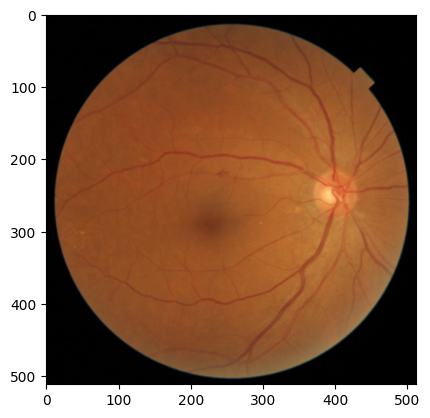

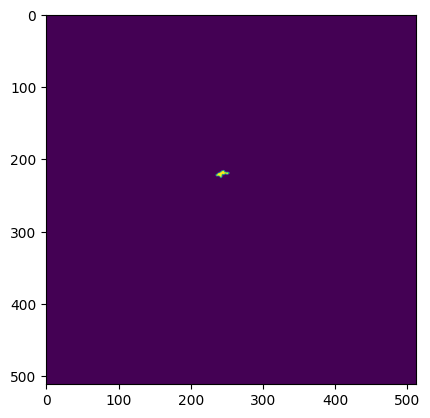

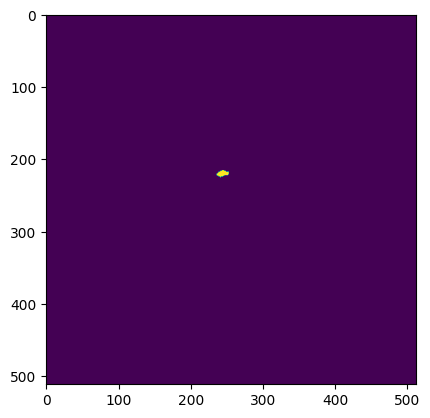

dataset_iou tensor(0.4556, device='cuda:0')
dataset_accuracy  tensor(0.9965, device='cuda:0')
dataset_recall tensor(0.6564, device='cuda:0')
dataset_precision tensor(0.5984, device='cuda:0')


Validation: 0it [00:00, ?it/s]

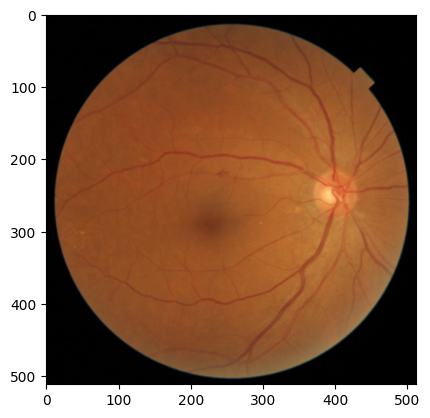

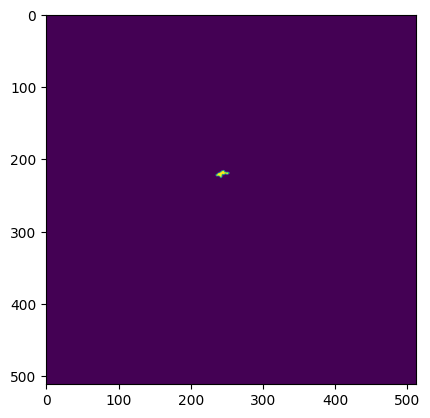

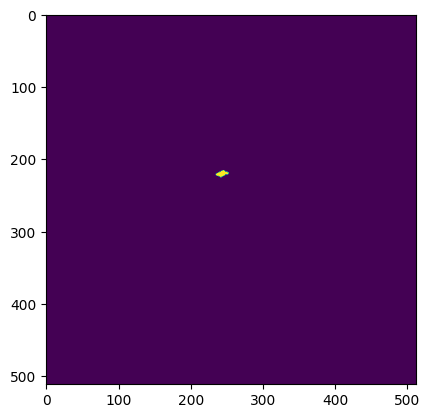

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=27` reached.


dataset_iou tensor(0.4601, device='cuda:0')
dataset_accuracy  tensor(0.9966, device='cuda:0')
dataset_recall tensor(0.6744, device='cuda:0')
dataset_precision tensor(0.5915, device='cuda:0')


In [ ]:
# train
LESION='HE'
train_data = SEGData('train',LESION)
val_data = TestData('valid',LESION)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)
archi,encoder="unet","resnet34"
model = DRsegModel(arch=archi,encoder_name=encoder, encoder_weights="imagenet", in_channels=3, out_classes=1)
checkpoint_callback = ModelCheckpoint(dirpath="/content/drive/MyDrive/DRseg/SAVE",
                  filename=LESION+"_"+archi+"_"+encoder+"_checkpoint",
                  every_n_train_steps=2,
                  )
trainer = pl.Trainer(
   devices="auto", accelerator="auto",
    max_epochs=27,callbacks=[checkpoint_callback] #向Trainer添加回调
)
test_data=TestData('test',LESION)
test_dataloader=DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)
trainer.fit(
    model,
    ckpt_path=CKPT_PATH+LESION+"_"+archi+"_"+encoder+"_checkpoint.ckpt",
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
# Test precisions on test dataset
archi,encoder="unet","resnet34"
LESION="HE"
test_model = DRsegModel.load_from_checkpoint(CKPT_PATH+LESION+"_"+archi+"_"+encoder+"_checkpoint.ckpt",arch=archi,encoder_name=encoder, encoder_weights="imagenet", in_channels=3, out_classes=1)
test_trainer = pl.Trainer()
data = TestData('test','HE')
test_dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)
test_trainer.test(test_model, dataloaders=test_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

dataset_iou tensor(0.2715, device='cuda:0')
dataset_accuracy  tensor(0.9960, device='cuda:0')
dataset_recall tensor(0.3220, device='cuda:0')
dataset_precision tensor(0.6337, device='cuda:0')


[{}]